In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

In [4]:
df = pd.read_csv("/home/kou552/crypto/archive/ETH_1H.csv")
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1586995200000,2020-04-16 00:00:00,ETHUSD,152.94,152.94,150.39,150.39,650.188125
1,1586991600000,2020-04-15 23:00:00,ETHUSD,155.81,155.81,151.39,152.94,4277.567299
2,1586988000000,2020-04-15 22:00:00,ETHUSD,157.18,157.30,155.32,155.81,106.337279
3,1586984400000,2020-04-15 21:00:00,ETHUSD,158.04,158.31,157.16,157.18,55.244131
4,1586980800000,2020-04-15 20:00:00,ETHUSD,157.10,158.10,156.87,158.04,144.262622


In [5]:
len(df)

34497

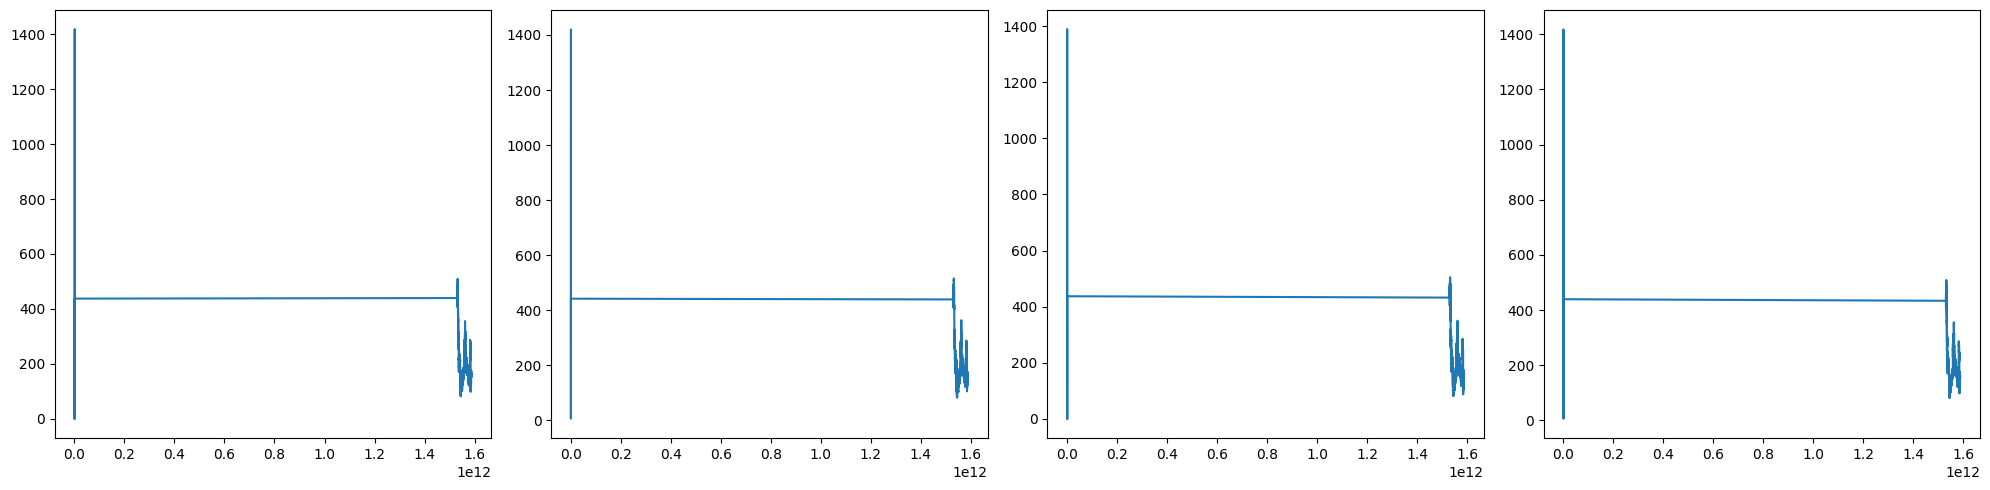

In [6]:
import matplotlib.pyplot as plt

figs, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].plot(df["Unix Timestamp"], df["Open"])
axes[1].plot(df["Unix Timestamp"], df["High"])
axes[2].plot(df["Unix Timestamp"], df["Low"])
axes[3].plot(df["Unix Timestamp"], df["Close"])

plt.tight_layout()
plt.show()

In [30]:
df.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,3.449700e+04,34497.000000,34497.000000,34497.000000,34497.000000,34497.000000
mean,7.147761e+11,239.172160,240.988877,237.142926,239.176415,1563.625471
std,7.758756e+11,237.205512,239.468230,234.532649,237.202348,7003.461234
min,1.462799e+09,0.000000,6.150000,0.000000,6.100000,0.000000
25%,1.493845e+09,81.020000,82.120000,79.980000,81.020000,101.092334
50%,1.524892e+09,181.870000,182.770000,180.820000,181.870000,444.684817
75%,1.555938e+12,298.070000,299.920000,296.380000,298.070000,1508.711881
max,1.586995e+12,1417.540000,1420.010000,1388.990000,1417.540000,903102.685700


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [14]:
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQNAgent:
    def __init__(self, input_size, hidden_size, output_size, lr, gamma, epsilon, memory_size, batch_size):
        self.device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size

        self.model = DQN(input_size, hidden_size, output_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.output_size)
        else:
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)
            q_values = self.model(state)
            _, action = torch.max(q_values, 1)
            return action.item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        # メモリからランダムにバッチを取得
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(np.array(batch.state), dtype=torch.float).to(self.device)
        action_batch = torch.tensor(np.array(batch.action), dtype=torch.long).unsqueeze(1).to(self.device)
        reward_batch = torch.tensor(np.array(batch.reward), dtype=torch.float).to(self.device)
        next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float).to(self.device)
        done_batch = torch.tensor(np.array(batch.done), dtype=torch.float).to(self.device)


        q_values = self.model(state_batch)
        next_q_values = self.model(next_state_batch)
        q_values = q_values.gather(1, action_batch).squeeze(1)
        next_q_values = torch.max(next_q_values, 1)[0]
        expected_q_value = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = self.criterion(q_values, expected_q_value.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self, epsilon):
        self.epsilon = max(0.01, min(1.0, 1.0 - np.log10((epsilon + 1) / 25)))

def train_dqn(env, agent, num_episodes):
    patience = 50  # 訓練を続けるエピソード数
    min_delta = 0.01  # 改善と見なされる報酬の最小値
    best_reward = -np.inf  # これまでの最高報酬
    reward_list = []  # 各エピソードの報酬を格納するリスト

    for episode in tqdm(range(num_episodes)):
        env.reset()
        state = env.state()
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            # 状態遷移をメモリに保存
            agent.memory.push(state, action, next_state, reward, done)
            agent.train()  # ここでは引数を与えない
            state = next_state
        
        agent.update_epsilon(episode)

        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode + 1}/{num_episodes}, Epsilon: {agent.epsilon}")

        if len(reward_list) > patience:
                avg_reward = np.mean(reward_list[-patience:])  # 過去Nエピソードの報酬の平均を計算
                if avg_reward - best_reward < min_delta:  # 改善が十分でなければ打ち切り
                    print("Training stopped: reward improvement has been below the threshold.")
                    break
                best_reward = max(best_reward, avg_reward)  # 最高報酬の更新

    print("Training complete.")

In [17]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [18]:
class CryptoTradingEnvironment:
    def __init__(self, data):
        self.data = data.dropna().reset_index(drop=True)
        self.reset()
        print(len(self.data))

    def reset(self):
        self.timestep = 0
        self.profit = 0
        self.shares_held = 0
        self.initial_account_balance = 10000
        self.account_balance = self.initial_account_balance
        self.previous_price = None

    def get_state_size(self):
        return 5

    def get_action_size(self):
        return 3
    
    def step(self, action):
        reward = 0
        done = False

        current_price = self.data.iloc[self.timestep]["Close"]

        if action == 0: # Buy
            if self.account_balance > current_price:
                self.shares_held += 1
                self.account_balance -= current_price
            else:
                reward -= 1

        elif action == 1: # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.account_balance += current_price
                reward += current_price - self.previous_price
            else:
                reward -= 1

        elif action == 2: # Hold
            pass

        self.timestep += 1

        if self.timestep >= len(self.data) - 1 or self.account_balance <= 0:  # Termination condition
            done = True

        if done:
            self.profit = self.account_balance - self.initial_account_balance
            reward += self.profit / self.initial_account_balance

        self.previous_price = current_price
        next_state = self._get_state()
        return next_state, reward, done, {}

    def state(self):
        return self._get_state()

    def _get_state(self):
        state = self.data.iloc[self.timestep].values[1:]
        if np.isnan(state).any():
            state = np.nan_to_num(state, nan=0.0).astype(np.float32)
        return state

この例では、reset()メソッドで環境を初期化し、step()メソッドでエージェントの行動に応じて次の状態を返し、報酬や終了条件を決定します。また、get_state_size()メソッドとget_action_size()メソッドを使用して、状態空間と行動空間の次元を取得します。

このクラスを使用するには、まずPandas DataFrameを作成し、それをCryptoTradingEnvironmentのインスタンス化時に渡す必要があります。

In [21]:
del df["Date"]
del df["Symbol"]
train_df, test_df = df[:int(len(df) * 0.8)], df[int(len(df) * 0.8):]

In [37]:
env = CryptoTradingEnvironment(train_df)

# hyperparameters
input_size = env.get_state_size() # データセットによって異なります
output_size = env.get_action_size() # アクションの種類
hidden_size = 128 # 任意の値
lr = 0.001 # 学習率
gamma = 0.99 # 割引率
epsilon = 0.9 # 探索パラメータ
memory_size = 10000 # replay memoryの容量
batch_size = 64 # バッチサイズ
num_episodes = 500 # エピソード数

# agentの作成
agent = DQNAgent(input_size, hidden_size, output_size, lr, gamma, epsilon, memory_size, batch_size)

# 環境とエージェントを使って訓練
train_dqn(env, agent, num_episodes)

27597


  2%|▏         | 10/500 [07:29<6:00:22, 44.13s/it]

Episode: 10/500, Epsilon: 1.0


  4%|▍         | 20/500 [14:24<5:29:03, 41.13s/it]

Episode: 20/500, Epsilon: 1.0


  6%|▌         | 30/500 [21:20<5:32:16, 42.42s/it]

Episode: 30/500, Epsilon: 0.9208187539523752


  8%|▊         | 40/500 [28:31<5:31:27, 43.23s/it]

Episode: 40/500, Epsilon: 0.7958800173440752


 10%|█         | 50/500 [35:31<5:09:01, 41.20s/it]

Episode: 50/500, Epsilon: 0.6989700043360187


 12%|█▏        | 60/500 [42:25<5:02:48, 41.29s/it]

Episode: 60/500, Epsilon: 0.619788758288394


 14%|█▍        | 70/500 [49:26<5:02:44, 42.24s/it]

Episode: 70/500, Epsilon: 0.5528419686577808


 16%|█▌        | 80/500 [56:34<5:01:07, 43.02s/it]

Episode: 80/500, Epsilon: 0.49485002168009395


 18%|█▊        | 90/500 [1:03:41<4:50:13, 42.47s/it]

Episode: 90/500, Epsilon: 0.44369749923271273


 20%|██        | 100/500 [1:10:53<4:48:15, 43.24s/it]

Episode: 100/500, Epsilon: 0.3979400086720376


 22%|██▏       | 110/500 [1:18:06<4:42:39, 43.49s/it]

Episode: 110/500, Epsilon: 0.3565473235138126


 24%|██▍       | 120/500 [1:25:26<4:42:03, 44.54s/it]

Episode: 120/500, Epsilon: 0.31875876262441283


 26%|██▌       | 130/500 [1:33:24<4:56:27, 48.07s/it]

Episode: 130/500, Epsilon: 0.2839966563652008


 28%|██▊       | 140/500 [1:41:50<5:12:43, 52.12s/it]

Episode: 140/500, Epsilon: 0.25181197299379954


 30%|███       | 150/500 [1:50:11<4:46:08, 49.05s/it]

Episode: 150/500, Epsilon: 0.22184874961635637


 32%|███▏      | 160/500 [1:58:13<4:31:08, 47.85s/it]

Episode: 160/500, Epsilon: 0.1938200260161128


 34%|███▍      | 170/500 [2:06:30<4:32:46, 49.60s/it]

Episode: 170/500, Epsilon: 0.16749108729376372


 36%|███▌      | 180/500 [2:14:40<4:21:18, 48.99s/it]

Episode: 180/500, Epsilon: 0.14266750356873148


 38%|███▊      | 190/500 [2:22:46<4:11:24, 48.66s/it]

Episode: 190/500, Epsilon: 0.11918640771920863


 40%|████      | 200/500 [2:30:47<3:53:02, 46.61s/it]

Episode: 200/500, Epsilon: 0.09691001300805646


 42%|████▏     | 210/500 [2:38:08<3:34:24, 44.36s/it]

Episode: 210/500, Epsilon: 0.0757207139381183


 44%|████▍     | 220/500 [2:45:29<3:25:07, 43.96s/it]

Episode: 220/500, Epsilon: 0.05551732784983132


 46%|████▌     | 230/500 [2:52:54<3:20:40, 44.60s/it]

Episode: 230/500, Epsilon: 0.03621217265444476


 48%|████▊     | 240/500 [3:00:20<3:15:48, 45.19s/it]

Episode: 240/500, Epsilon: 0.017728766960431575


 50%|█████     | 250/500 [3:07:47<3:06:20, 44.72s/it]

Episode: 250/500, Epsilon: 0.01


 52%|█████▏    | 260/500 [3:15:09<2:56:51, 44.21s/it]

Episode: 260/500, Epsilon: 0.01


 54%|█████▍    | 270/500 [3:22:34<2:49:35, 44.24s/it]

Episode: 270/500, Epsilon: 0.01


 56%|█████▌    | 280/500 [3:29:58<2:43:30, 44.59s/it]

Episode: 280/500, Epsilon: 0.01


 58%|█████▊    | 290/500 [3:37:27<2:38:17, 45.23s/it]

Episode: 290/500, Epsilon: 0.01


 60%|██████    | 300/500 [3:44:51<2:28:06, 44.43s/it]

Episode: 300/500, Epsilon: 0.01


 62%|██████▏   | 310/500 [3:52:17<2:20:47, 44.46s/it]

Episode: 310/500, Epsilon: 0.01


 64%|██████▍   | 320/500 [3:59:45<2:14:27, 44.82s/it]

Episode: 320/500, Epsilon: 0.01


 66%|██████▌   | 330/500 [4:07:21<2:13:33, 47.14s/it]

Episode: 330/500, Epsilon: 0.01


 68%|██████▊   | 340/500 [4:15:40<2:12:04, 49.53s/it]

Episode: 340/500, Epsilon: 0.01


 70%|███████   | 350/500 [4:24:01<2:04:41, 49.87s/it]

Episode: 350/500, Epsilon: 0.01


 72%|███████▏  | 360/500 [4:32:21<1:54:54, 49.25s/it]

Episode: 360/500, Epsilon: 0.01


 74%|███████▍  | 370/500 [4:39:46<1:36:40, 44.62s/it]

Episode: 370/500, Epsilon: 0.01


 76%|███████▌  | 380/500 [4:47:11<1:28:37, 44.31s/it]

Episode: 380/500, Epsilon: 0.01


 78%|███████▊  | 390/500 [4:54:38<1:22:18, 44.89s/it]

Episode: 390/500, Epsilon: 0.01


 80%|████████  | 400/500 [5:02:05<1:14:26, 44.67s/it]

Episode: 400/500, Epsilon: 0.01


 82%|████████▏ | 410/500 [5:09:30<1:06:37, 44.41s/it]

Episode: 410/500, Epsilon: 0.01


 84%|████████▍ | 420/500 [5:16:57<59:27, 44.60s/it]  

Episode: 420/500, Epsilon: 0.01


 86%|████████▌ | 430/500 [5:24:25<52:24, 44.92s/it]

Episode: 430/500, Epsilon: 0.01


 88%|████████▊ | 440/500 [5:31:53<45:08, 45.14s/it]

Episode: 440/500, Epsilon: 0.01


 90%|█████████ | 450/500 [5:39:19<37:00, 44.40s/it]

Episode: 450/500, Epsilon: 0.01


 92%|█████████▏| 460/500 [5:46:45<29:31, 44.30s/it]

Episode: 460/500, Epsilon: 0.01


 94%|█████████▍| 470/500 [5:54:11<22:20, 44.67s/it]

Episode: 470/500, Epsilon: 0.01


 96%|█████████▌| 480/500 [6:01:41<14:58, 44.91s/it]

Episode: 480/500, Epsilon: 0.01


 98%|█████████▊| 490/500 [6:09:03<07:21, 44.12s/it]

Episode: 490/500, Epsilon: 0.01


100%|██████████| 500/500 [6:16:28<00:00, 45.18s/it]

Episode: 500/500, Epsilon: 0.01
Training complete.


In [43]:
torch.save(agent.model,"model_3.pth")

In [44]:
def test_dqn(env, agent, num_episodes):
    rewards = []

    for episode in range(num_episodes):
        env.reset()
        state = env.state()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    average_reward = sum(rewards) / num_episodes
    print(f"Average reward over {num_episodes} episodes: {average_reward}")

In [2]:
test_df = df[int(len(df) * 0.8):int(len(df) * 0.9)]
env = CryptoTradingEnvironment(test_df)

NameError: name 'df' is not defined

In [41]:
env = CryptoTradingEnvironment(train_df)

27597


In [26]:
# Load the saved model
model = torch.load("model_500epi.pth")

env=CryptoTradingEnvironment(test_df)
input_size = env.get_state_size() # データセットによって異なります
output_size = env.get_action_size() # アクションの種類
hidden_size = 128 # 任意の値
lr = 0.001 # 学習率
gamma = 0.99 # 割引率
epsilon = 0.9 # 探索パラメータ
memory_size = 10000 # replay memoryの容量
batch_size = 64 # バッチサイズ
num_episodes = 500 # エピソード数
# Create a new instance of DQNAgent using the loaded model
agent = DQNAgent(input_size, hidden_size, output_size, lr, gamma, epsilon, memory_size, batch_size)
agent.model = model

num_tests = 100  # テストの回数を指定
profits = []  # 各テストの実現損益を格納するリスト


for _ in range(num_tests):
    env.reset()
    state = env.state()
    done = False

    initial_account_balance = 10000  # 初期資産を設定
    account_balance = initial_account_balance
    while not done:
        action = agent.select_action(state)  # RandomAgentのインスタンスに対してselect_action()を呼び出す
        next_state, reward, done, _ = env.step(action)

        # 取引の実行
        current_price = env.data.iloc[env.timestep]["Close"]
        
        if action == 0:  # buy
            if account_balance > current_price:
                account_balance -= current_price
            else:
                reward = 0

        elif action == 1:  # sell
            if env.shares_held > 0:
                account_balance += current_price

        state = next_state

    profit = account_balance - initial_account_balance
    profits.append(profit)  # 実現損益をリストに追加

average_profit = sum(profits) / num_tests  # 実現損益の平均を計算

print(f"Average profit: {average_profit}")


6900
Average profit: -1116.3887000000077


In [36]:
env.reset()
state = env.state()
done = False

initial_account_balance = 10000  # 初期資産を設定
account_balance = initial_account_balance

action_counter = {0: 0, 1: 0, 2: 0}  # Initializing action counter

while not done:
    action = agent.select_action(state)
    action_counter[action] += 1  # Update action counter
    next_state, reward, done, _ = env.step(action)

    # Execute trades
    if action == 0:  # buy
        if account_balance > env.data.iloc[env.timestep]["Close"]:
            account_balance -= env.data.iloc[env.timestep]["Close"]
        else:
            reward -= 1

    elif action == 1:  # sell
        if env.shares_held > 0:
            account_balance += env.data.iloc[env.timestep]["Close"]
            reward += 1

    state = next_state

profit = account_balance - initial_account_balance
print(f"Total profit: {profit}")
print(f"Action counter: {action_counter}")  # Print action counts

Total profit: -737.1899999999714
Action counter: {0: 2082, 1: 2032, 2: 2785}
